In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

# 데이터 가져오기
df = pd.read_csv('housingdata.csv')

df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [14]:
# 데이터 분리
X = df.drop(columns=['MEDV'])
y = df['MEDV']

# 데이터를 학습(train) 및 테스트(test) 세트로 나눔 (훈련: 80%, 테스트: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# 결측치 처리 (훈련 데이터에서 학습한 imputer를 사용해 테스트 데이터 처리)
# IterativeImputer를 사용해 결측치를 예측 기반으로 대체

# 결측치 처리 (훈련 데이터에서 fit, 테스트 데이터는 transform만 적용)
# imputer = IterativeImputer(estimator=LinearRegression(), random_state=42)
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42))

# 훈련 데이터 결측치 처리
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# 테스트 데이터의 결측치 처리 (훈련 데이터의 학습 결과를 적용)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# 결측치가 잘 처리되었는지 확인
print("결측치 처리 후 훈련 데이터 결측치:", X_train_imputed.isnull().sum().sum())
print("결측치 처리 후 테스트 데이터 결측치:", X_test_imputed.isnull().sum().sum())

결측치 처리 후 훈련 데이터 결측치: 0
결측치 처리 후 테스트 데이터 결측치: 0


In [16]:
# 이상치 탐지
# IsolationForest를 사용해 이상치 탐지, contamination=0.05는 이상치 비율을 5%로 설정
clf = IsolationForest(contamination=0.05, random_state=42)

# 이상치 여부를 'anomaly' 열에 저장
X_train_imputed['anomaly'] = clf.fit_predict(X_train_imputed)

In [17]:
# 이상치 및 정상 데이터의 개수 확인
print(X_train_imputed['anomaly'].value_counts())  # 정상(1), 이상치(-1) 개수 확인

# X_train_imputed 열 목록
print(X_train_imputed.columns)

anomaly
 1    383
-1     21
Name: count, dtype: int64
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'anomaly'],
      dtype='object')


In [18]:
# 이상치 데이터와 정상 데이터 분리
outliers = X_train_imputed[X_train_imputed['anomaly'] == -1]  # 이상치 행
non_outliers = X_train_imputed[X_train_imputed['anomaly'] != -1]  # 정상 행

# 이상치 데이터 확인
outliers

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,anomaly
20,73.534100,0.0,18.10,0.0,0.6790,5.957,100.000,1.8026,24.0,666.0,20.2,16.45,20.62,-1
26,3.535010,0.0,19.58,1.0,0.8710,6.152,94.425,1.7455,5.0,403.0,14.7,88.01,15.02,-1
44,1.413850,0.0,19.58,1.0,0.8710,6.129,96.000,1.7494,5.0,403.0,14.7,321.02,15.12,-1
78,2.779740,0.0,19.58,0.0,0.8710,4.903,97.800,1.3459,5.0,403.0,14.7,396.90,29.29,-1
81,8.982960,0.0,18.10,1.0,0.7700,6.212,97.400,2.1222,24.0,666.0,20.2,377.73,17.60,-1
86,9.511001,0.0,18.10,1.0,0.6310,6.683,96.800,1.3567,24.0,666.0,20.2,375.33,3.73,-1
97,2.379340,0.0,19.58,0.0,0.8710,6.130,100.000,1.4191,5.0,403.0,14.7,172.91,27.80,-1
105,1.519020,0.0,19.58,1.0,0.6050,8.375,93.057,2.1620,5.0,403.0,14.7,388.45,3.32,-1
135,3.474280,0.0,18.10,1.0,0.7180,8.780,82.900,1.9047,24.0,666.0,20.2,354.55,5.29,-1
156,2.155050,0.0,19.58,0.0,0.8710,5.628,100.000,1.5166,5.0,403.0,14.7,169.27,16.65,-1


In [19]:
# 이상치 대체
# 이상치 열을 하나씩 반복 처리하며 랜덤 포레스트로 대체값 예측
independent_columns = X_train.columns
for col in independent_columns:
    features = [c for c in independent_columns if c != col]
    clean_features = non_outliers[features]  # 정상 데이터
    target = non_outliers[col]  # 현재 열 값

    # 랜덤 포레스트로 대체 값 예측
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(clean_features, target)
    predicted_values = model.predict(outliers[features])

    # 예측값으로 이상치 대체
    X_train_imputed.loc[outliers.index, col] = predicted_values

# 이상치 대체 결과 확인
X_train_imputed.loc[outliers.index]  # 대체된 이상치 데이터 출력

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,anomaly
20,17.349938,0.00000,18.100000,0.0000,0.680440,6.26222,84.50200,1.756248,24.00,666.00,20.200,262.9169,25.378300,-1
26,1.612980,0.00000,19.565200,0.1250,0.740210,5.78464,84.34600,1.997709,8.03,405.02,14.700,348.8453,13.614792,-1
44,1.410990,0.00000,19.580000,0.1175,0.742080,5.60906,92.31074,1.844462,5.00,400.75,14.700,343.2241,11.987200,-1
78,3.679338,0.00000,19.580000,0.0950,0.851020,5.21586,97.50319,1.465077,6.40,406.50,14.683,376.6504,23.896166,-1
81,8.935228,0.00000,18.100000,0.3500,0.681720,6.34380,93.30188,1.820102,24.00,666.00,20.200,332.9893,17.705609,-1
86,13.504603,0.00660,18.100000,0.0252,0.666850,5.96382,93.95039,1.732061,24.00,666.00,20.145,331.7844,18.617904,-1
97,4.997825,0.00000,19.580000,0.1050,0.797790,5.49744,90.42351,1.816997,5.75,403.29,14.700,363.1960,15.093943,-1
105,1.666506,0.01650,19.423900,0.1409,0.647270,7.68322,92.69700,1.978213,5.05,397.10,14.666,338.5032,6.232256,-1
135,23.604852,0.01650,17.984093,0.0564,0.681110,6.73472,92.44310,2.446837,24.00,666.00,20.090,297.3416,10.773892,-1
156,2.045955,0.00000,19.580000,0.0950,0.771590,5.78842,92.49055,1.849128,5.00,403.29,14.700,343.9595,19.327200,-1


In [20]:
# 'anomaly' 열 제거
X_train_imputed.drop(columns=['anomaly'], inplace=True)

# 최종 확인
X_train_imputed

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,15.02340,0.00,18.10,0.0,0.6140,5.304,97.300,2.1007,24.0,666.0,20.2,349.48,24.91
1,0.62739,0.00,8.14,0.0,0.5380,5.834,56.500,4.4986,4.0,307.0,21.0,395.62,8.47
2,0.03466,27.88,6.06,0.0,0.4379,6.031,23.300,6.6407,1.0,304.0,16.9,362.25,7.83
3,7.05042,0.00,18.10,0.0,0.6140,6.103,88.303,2.0218,24.0,666.0,20.2,2.52,23.29
4,0.72580,0.00,8.14,0.0,0.5380,5.727,69.500,3.7965,4.0,307.0,21.0,390.95,11.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.17120,0.00,8.56,0.0,0.5200,5.836,91.900,2.2110,5.0,384.0,20.9,395.67,18.66
400,0.29916,20.00,6.96,0.0,0.4640,5.856,42.100,4.4290,3.0,223.0,18.6,388.65,13.00
401,0.01501,80.00,2.01,0.0,0.4350,6.635,29.700,8.3440,4.0,280.0,17.0,390.94,5.99
402,11.16040,0.00,18.10,0.0,0.7400,6.629,94.600,2.1247,24.0,666.0,20.2,109.85,23.27


In [21]:
# 데이터 스케일링
# StandardScaler를 사용해 평균 0, 표준편차 1로 변환
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns)


선형회귀 교차검증
CV MSE: 28.621900219491394
CV MAE: 3.4924552817561376
CV R^2: 0.6700542755406174
Fitting 3 folds for each of 81 candidates, totalling 243 fits
RandomForest best_params_:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest best_score_:  19.57870928808794
Fitting 3 folds for each of 50 candidates, totalling 150 fits
GradientBoosting best_params_:  {'learning_rate': 0.1002634929450309, 'max_depth': 3, 'n_estimators': 130, 'subsample': 0.7800343042825855}
GradientBoosting best_score_:  15.955306109836917
     LinearRegression  RandomForest  GradientBoosting
MAE          3.247274      1.967427          1.921951
MSE         26.303018      7.203232          6.501112
R^2          0.641325      0.901775          0.911349


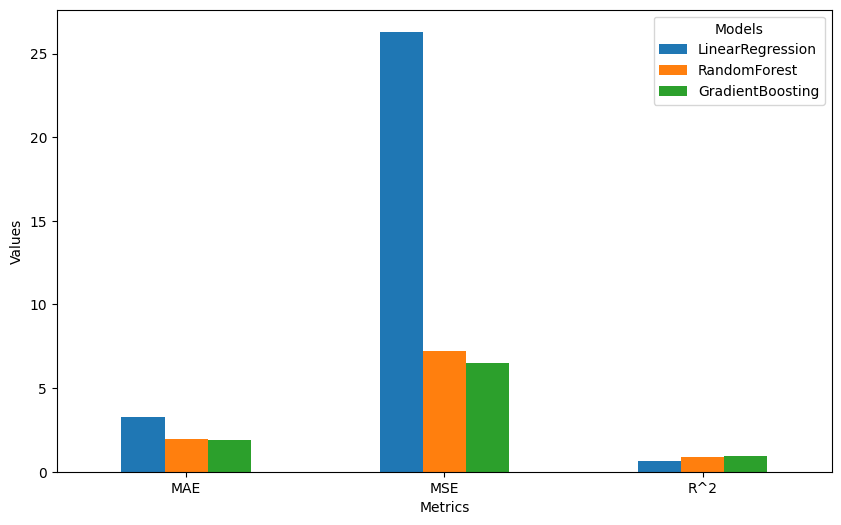

In [22]:
# 선형 회귀 모델 학습 및 평가
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# 평가 지표 계산 (MAE, MSE, R^2)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

# 교차 검증으로 성능 평가
cv_results_lr = cross_validate(lr_model, X_train_scaled, y_train, cv=3, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
print("선형회귀 교차검증")
print(f"CV MSE: {-cv_results_lr['test_neg_mean_squared_error'].mean()}")
print(f"CV MAE: {-cv_results_lr['test_neg_mean_absolute_error'].mean()}")
print(f"CV R^2: {cv_results_lr['test_r2'].mean()}")

# 랜덤 포레스트 하이퍼파라미터 튜닝 (GridSearchCV)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

rf_grid_search.fit(X_train_scaled, y_train)
print("RandomForest best_params_: ", rf_grid_search.best_params_)
print("RandomForest best_score_: ", -rf_grid_search.best_score_)

# GradientBoosting 하이퍼파라미터 튜닝 (RandomizedSearchCV)
gb_param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3)
}

gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

gb_random_search.fit(X_train_scaled, y_train)
print("GradientBoosting best_params_: ", gb_random_search.best_params_)
print("GradientBoosting best_score_: ", -gb_random_search.best_score_)

# 최적화된 모델 평가
final_models = {
    "LinearRegression": lr_model,
    "RandomForest": rf_grid_search.best_estimator_,
    "GradientBoosting": gb_random_search.best_estimator_
}

# 모델별 성능 비교
results = {}
for name, model in final_models.items():
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "R^2": r2}

# 결과 저장 및 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
results_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(title="Models")
plt.xticks(rotation=0)
plt.show()
